### Setting up the Working Environment

In [1]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


## Depth Estimation using Dense Prediction Transformers DPT from Intel.

In [5]:
from transformers import pipeline
depth_estimator = pipeline("depth-estimation", model="Intel/dpt-hybrid-midas")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

### Loading the Raw Image and resizing it to these dimensions : (806 , 621 )

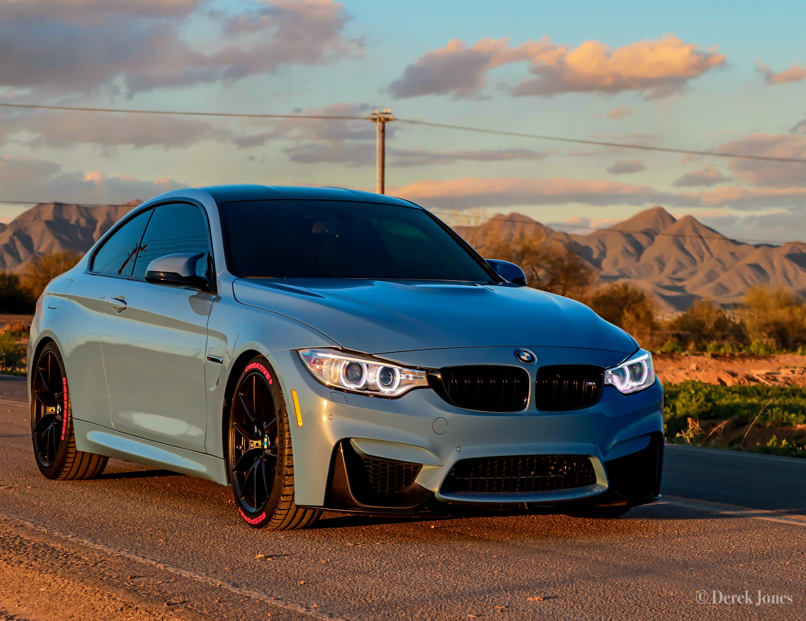

In [7]:
from PIL import Image
raw_image = Image.open('R.jpg')
raw_image.resize((806, 621))

## Processing the raw Image; the output is a depth map

In [8]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [2823.1365, 2825.0295, 2823.7444,  ..., 2458.8845, 2454.3367,
           2453.9910],
          [2847.7864, 2844.5281, 2846.0383,  ..., 2471.4253, 2478.1162,
           2471.4592],
          [2844.2788, 2858.5735, 2853.7981,  ..., 2494.2141, 2499.2571,
           2502.8752]]]),
 'depth': <PIL.Image.Image image mode=L size=6000x4000>}

## This depth map provides a 2D representation of the distance of objects in the image from the camera

## we will post-process the output image to resize it to the size of the original image.

In [9]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

## we will add dimension to the predicted depth map, turning it from a 2D tensor (H, W) into a 3D tensor (H, 1, W). The .shape function then returns the dimensions of this new tensor, allowing you to verify that the operation was performed correctly.

In [10]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

## We will resize the predicted depth map to match the original image's dimensions using bicubic interpolation for smooth results. The resized tensor will have the same height and width as the original image, ensuring proper dimensions when checked with prediction.shape.

In [12]:
import torch
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)
prediction.shape

torch.Size([1, 1, 4000, 6000])

## Next, we will be reversing the size order is necessary because the interpolate function expects the target size as, not (width, height)

In [13]:
raw_image.size[::-1]

(4000, 6000)

## Finally, we will print the predictions

In [14]:
prediction

tensor([[[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [2842.2964, 2842.1631, 2842.1062,  ..., 2506.7529, 2506.7358,
           2506.6965],
          [2842.2759, 2842.1423, 2842.0852,  ..., 2506.8816, 2506.8650,
           2506.8247],
          [2842.3225, 2842.1902, 2842.1335,  ..., 2506.5908, 2506.5742,
           2506.5347]]]])

## Additionally, we will normalize the predicted tensors (between 0 and 255) so that they can be displayed.

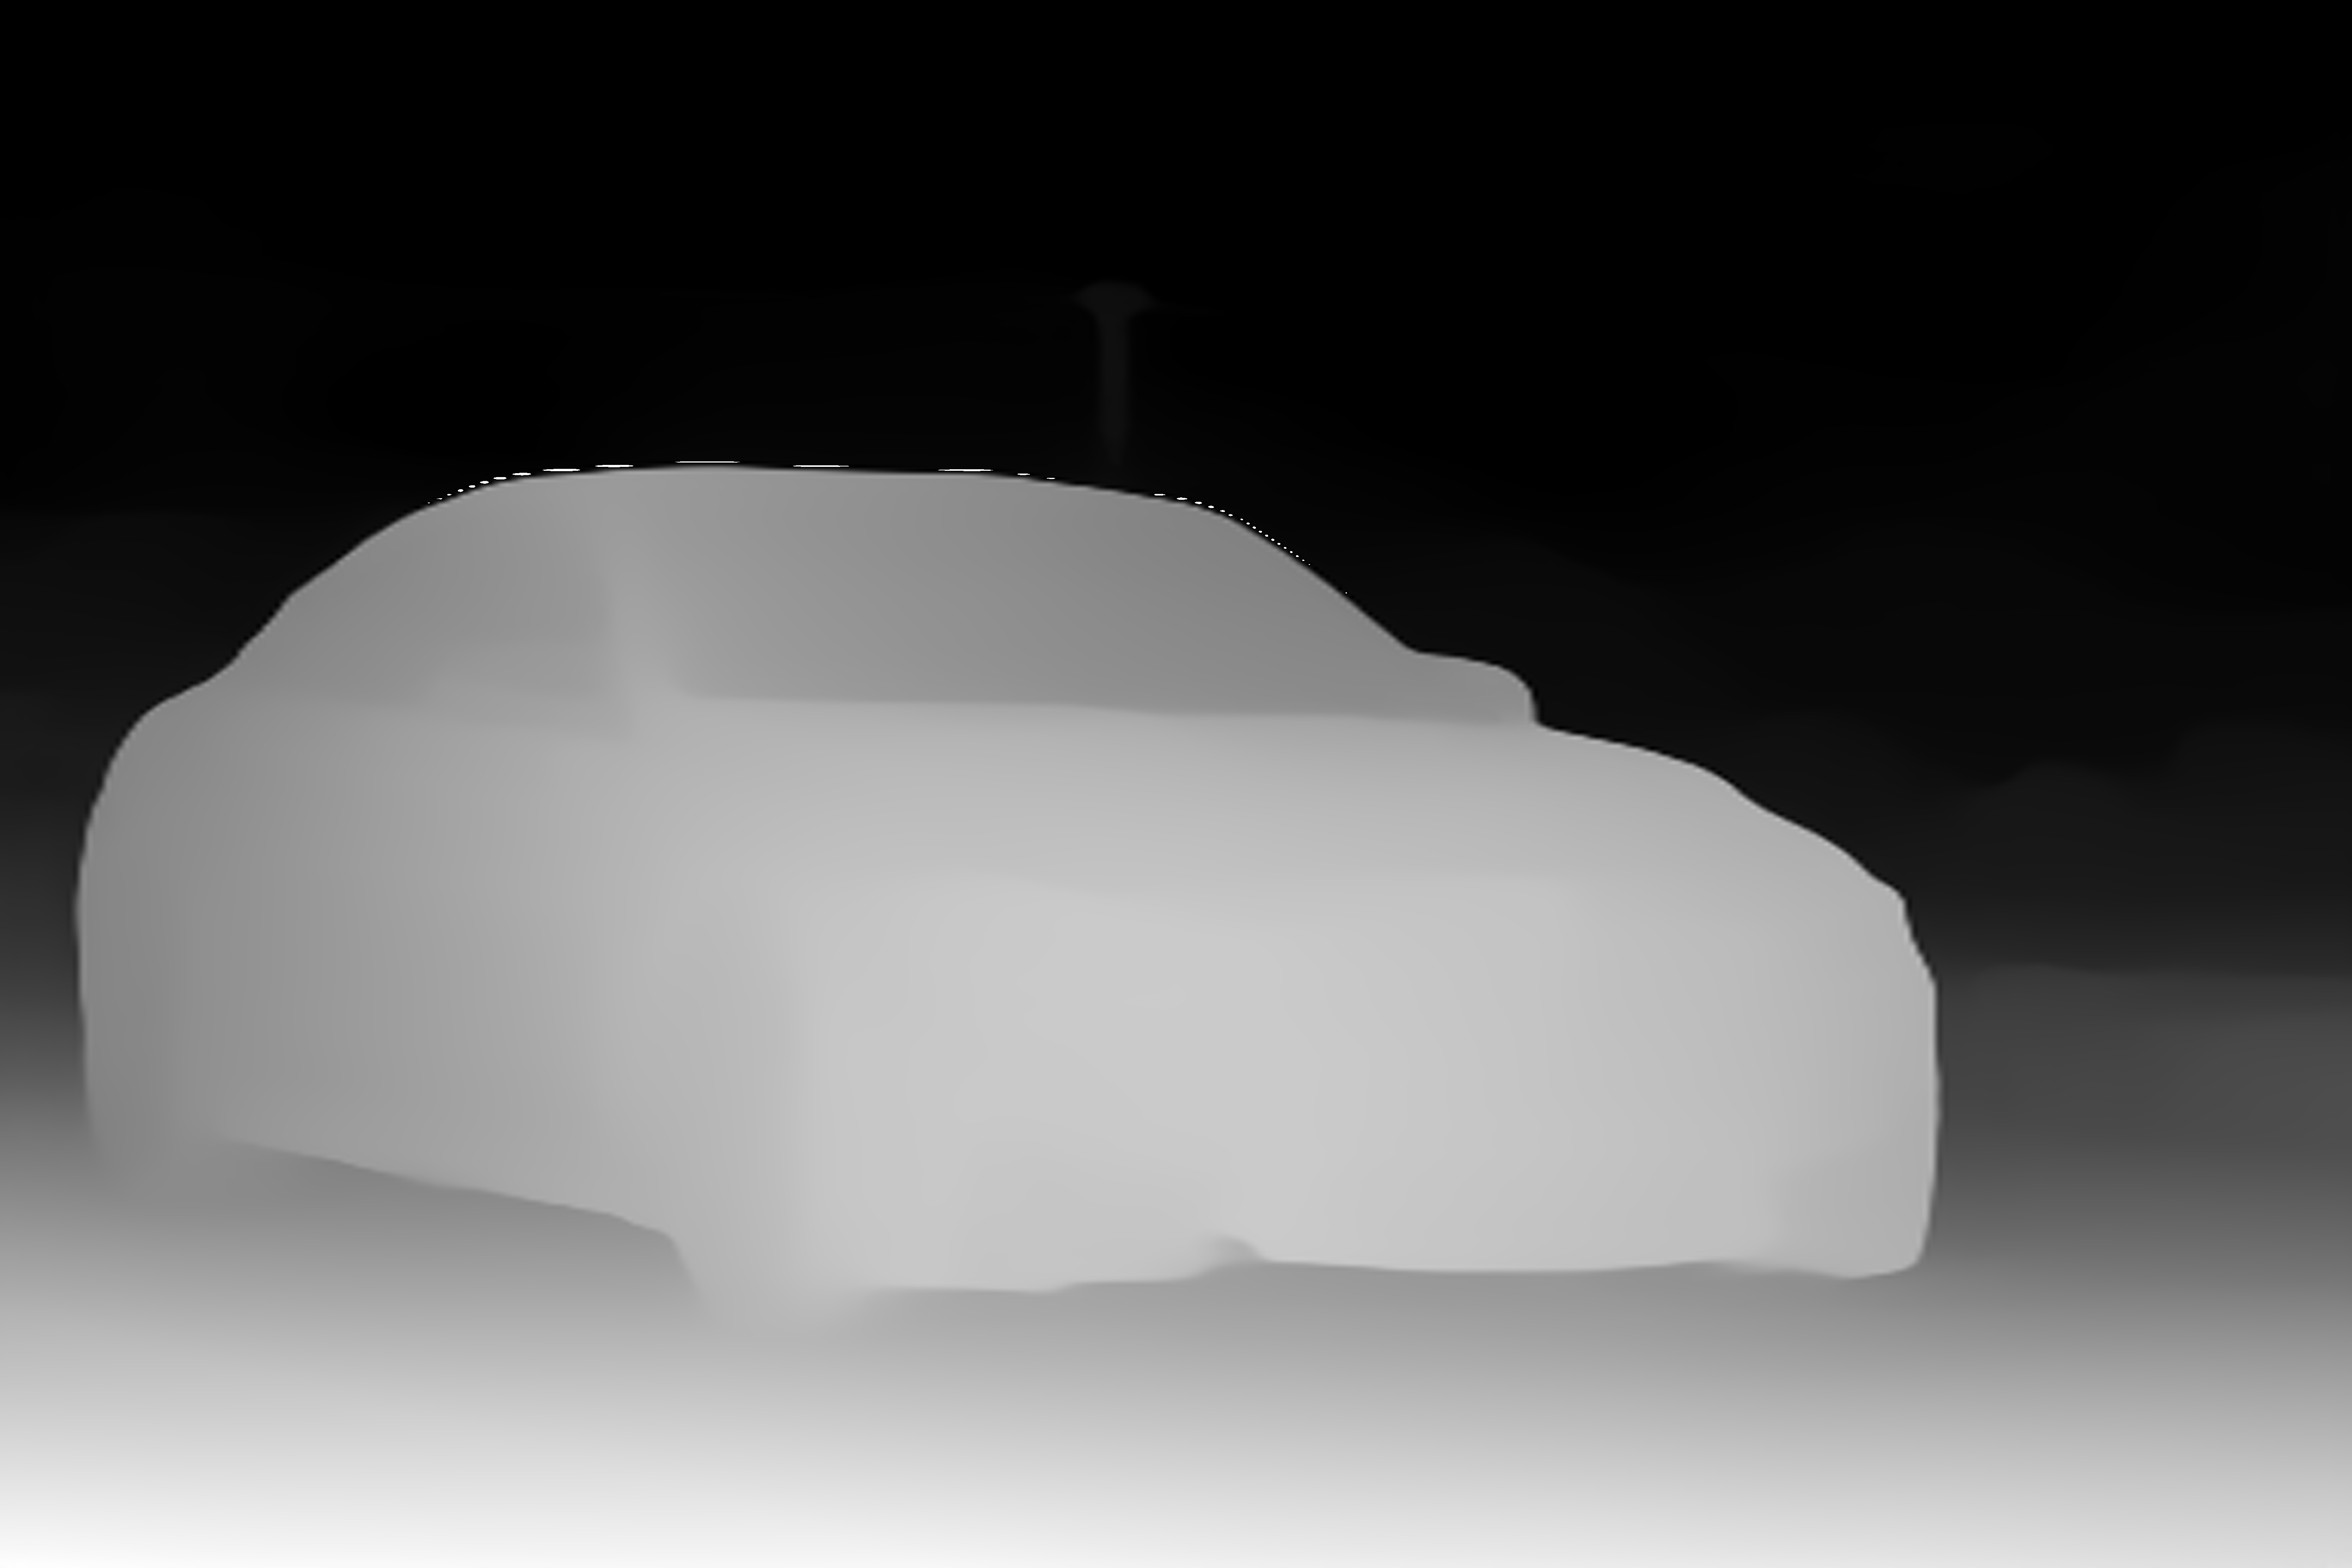

In [17]:
import numpy as np
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

# The next step is to build a demo for this application using Gardio. We will start by importing the required packages and libraries.

In [18]:
import os
import gradio as gr
from transformers import pipeline

## The launch function is central to our application. It processes an input image by performing depth estimation to create a depth map. This map is then resized to match the original image's dimensions, normalized, and converted into a grayscale image. In the resulting image, brighter pixels represent objects closer to the camera, while darker pixels signify objects that are further away.

In [19]:
def launch(input_image):
    out = depth_estimator(input_image)
    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [23]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

port = int(os.environ.get('PORT', 7860))  # Use 7860 as default

iface.launch(share=True, server_port=port)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://77fa68fa7cbc25ba4f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
